In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [2]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, T-Cells (a type of white blood cells)
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, thyroid stimulating hormone
      - s5      ltg, lamotrigine
      - s6      glu, blood sugar level

Note: Each of these 10 feature va

In [3]:
# Save the input and target variables

data = diabetes_dataset['data']
targets = diabetes_dataset['target']

In [4]:
# Normalise the target data (this will make clearer training curves)

targets = (targets - targets.mean(axis=0)) / targets.std(axis=0)

In [5]:
# Split the data into train and test sets

from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [6]:
# Build the model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1),
    ])
    return model

model = get_model()

In [7]:
# Print the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [8]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [9]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)

In [10]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 1.2954 - mae: 0.8062


[1.2954121828079224, 0.8062071204185486]

#### Plot the learning curves

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

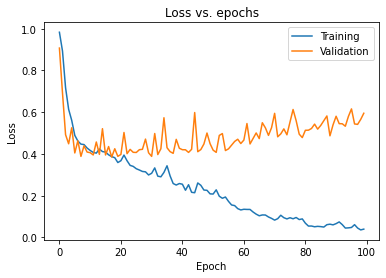

In [12]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [13]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [14]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [15]:
# Re-build the model with weight decay and dropout layers

model = get_regularised_model(1e-5, 0.3)

In [16]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)

In [18]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.9410 - mae: 0.7293


[0.9409518837928772, 0.7293487787246704]

#### Plot the learning curves

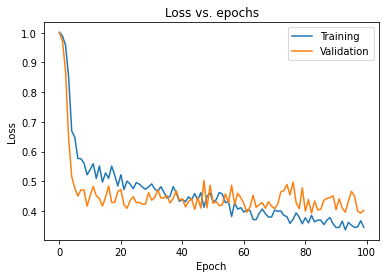

In [19]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [20]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class MyCallback(Callback):
        
    def on_train_begin(self, logs=None):
        print("Starting training.....")
        
    def on_train_batch_begin(self, batch, logs=None):
        print("Traning: Starting batch", batch)
        
    def on_train_batch_end(self, batch, logs=None):
        print("Traning: Finished batch", batch)

    def on_train_end(self, logs=None):
        print("Finished training!")
    
    def on_epoch_begin(self, epoch, logs=None):
        print("Starting epoch", epoch)
        
    def on_epoch_end(self, epoch, logs=None):
        print("Finished epoch", epoch)
        
    def on_test_begin(self, logs=None):
        print("Starting testing.....")
        
    def on_test_batch_begin(self, batch, logs=None):
        print("Testing: Starting batch", batch)
        
    def on_test_batch_end(self, batch, logs=None):
        print("Testing: Finished batch", batch)

    def on_test_end(self, logs=None):
        print("Finished testing!")
        
    def on_predict_begin(self, logs=None):
        print("Starting prediction.....")
        
    def on_predict_batch_begin(self, batch, logs=None):
        print("Prediction: Starting batch", batch)
        
    def on_predict_batch_end(self, batch, logs=None):
        print("Prediction: Finished batch", batch)

    def on_predict_end(self, logs=None):
        print("Finished prediction!")

In [21]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [22]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [23]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[MyCallback()])

Starting training.....
Starting epoch 0
Traning: Starting batch 0
Traning: Finished batch 0
Traning: Starting batch 1
Traning: Finished batch 1
Traning: Starting batch 2
Traning: Finished batch 2
Traning: Starting batch 3
Traning: Finished batch 3
Finished epoch 0
Starting epoch 1
Traning: Starting batch 0
Traning: Finished batch 0
Traning: Starting batch 1
Traning: Finished batch 1
Traning: Starting batch 2
Traning: Finished batch 2
Traning: Starting batch 3
Traning: Finished batch 3
Finished epoch 1
Starting epoch 2
Traning: Starting batch 0
Traning: Finished batch 0
Traning: Starting batch 1
Traning: Finished batch 1
Traning: Starting batch 2
Traning: Finished batch 2
Traning: Starting batch 3
Traning: Finished batch 3
Finished epoch 2
Finished training!


In [24]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[MyCallback()])

Starting testing.....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.9931052327156067

In [25]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[MyCallback()])

Starting prediction.....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!


array([[-0.0765404 ],
       [ 0.03836181],
       [-0.03639224],
       [ 0.0010717 ],
       [ 0.0426548 ],
       [ 0.02272867],
       [ 0.01830056],
       [-0.03678708],
       [-0.08073612],
       [-0.09225612],
       [-0.05194667],
       [ 0.0082875 ],
       [-0.038258  ],
       [-0.021108  ],
       [ 0.03970512],
       [ 0.0545589 ],
       [-0.07155009],
       [ 0.05753009],
       [-0.06498718],
       [ 0.02800293],
       [ 0.04167516],
       [ 0.01007808],
       [-0.08132178],
       [-0.05835918],
       [-0.0269464 ],
       [-0.08308064],
       [-0.08611733],
       [-0.04359243],
       [ 0.0641792 ],
       [-0.00153143],
       [-0.05345478],
       [-0.06529373],
       [ 0.01049535],
       [ 0.00928646],
       [ 0.01072578],
       [ 0.01730572],
       [-0.08198575],
       [-0.06095312],
       [-0.07965464],
       [ 0.03724974],
       [ 0.02018204],
       [ 0.05274298],
       [ 0.00910007],
       [-0.02426388],
       [ 0.05732857]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [26]:
# Re-train the unregularised model

unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100,
                                       validation_split=0.15, batch_size=64, verbose=False,
                                       callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [27]:
# Evaluate the model on the test set

unregularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.6715


0.6714683771133423

In [28]:
# Re-train the regularised model

regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam', loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                    validation_split=0.15, batch_size=64, verbose=False,
                                    callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

In [29]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=2)

2/2 - 0s - loss: 0.7936


0.7936212420463562

#### Plot the learning curves

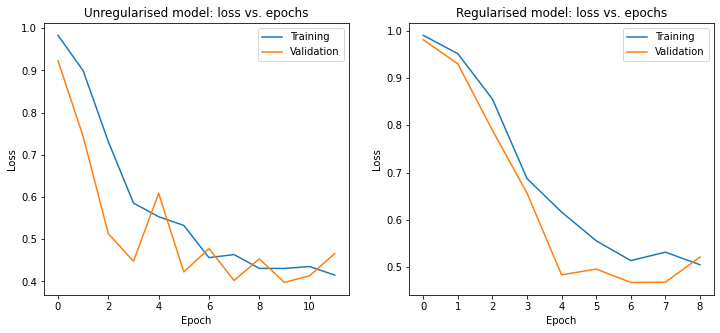

In [30]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()